In [ ]:
!pip uninstall pygments

Found existing installation: Pygments 2.16.1
Uninstalling Pygments-2.16.1:
  Would remove:
    /usr/local/bin/pygmentize
    /usr/local/lib/python3.10/dist-packages/Pygments-2.16.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pygments/*
Proceed (Y/n)? y
  Successfully uninstalled Pygments-2.16.1


In [ ]:
!pip install lightning
!pip install pigments
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 22.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-m

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [ ]:
import datasets
import lightning as pl
import matplotlib.pyplot as plt
import torch
import random
from lightning import Trainer
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage
from transformers import AutoFeatureExtractor
from transformers import AutoModelForObjectDetection

In [ ]:
def fix_channels(img):
    if len(img.shape) == 2:
        return ToPILImage()(torch.stack([img for i in (0, 0, 0)]))
    if img.shape[0] == 4:
        return ToPILImage()(img[:3])
    if img.shape[0] == 1:
        return ToPILImage()(torch.stack([img[0] for i in (0, 0, 0)]))
    return ToPILImage()(img)


def xyxy_to_xcycwh(box):

    x1, y1, x2, y2 = box.unbind(dim=1)
    width = x2-x1
    height = y2-y1
    xc = x1 + width*0.5
    yc = y1 + height*0.5
    b = [xc, yc, width, height]
    return torch.stack(b, dim=1)

def cxcywh_to_xyxy(x):

    x_c, y_c, w, h = x.unbind(1)
    x1 = x_c - 0.5 * w
    y1 = y_c - 0.5 * h
    x2 = x_c + 0.5 * w
    y2 = y_c + 0.5 * h
    b = [x1, y1, x2, y2]
    return torch.stack(b, dim=1)

In [ ]:
COLORS = ['lightcoral', 'yellowgreen', 'darkturquoise', 'hotpink', 'mediumslateblue']

def rescale_bboxes(out_bbox, size, down=True):
    img_w, img_h = size
    if down:
        b = torch.Tensor(out_bbox) / torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    if not down:
        b = torch.Tensor(out_bbox) * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, boxes, class_labels):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for (xmin, ymin, xmax, ymax), c, label in zip(boxes, colors, class_labels):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        ax.text(xmin, ymin, str(label), fontsize=15,
                bbox=dict(facecolor=c, alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
train_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train",from_=0, to=95, unit="%", rounding="pct1_dropremainder"))
val_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train",from_=95, to=100, unit="%", rounding="pct1_dropremainder"))

In [ ]:
cats = train_dataset.features['objects'].feature['category']

In [ ]:
def idx_to_text(indexes):
    labels = []
    for i in indexes:
        labels.append(cats.names[i])
    return labels

Plotting random item 1969


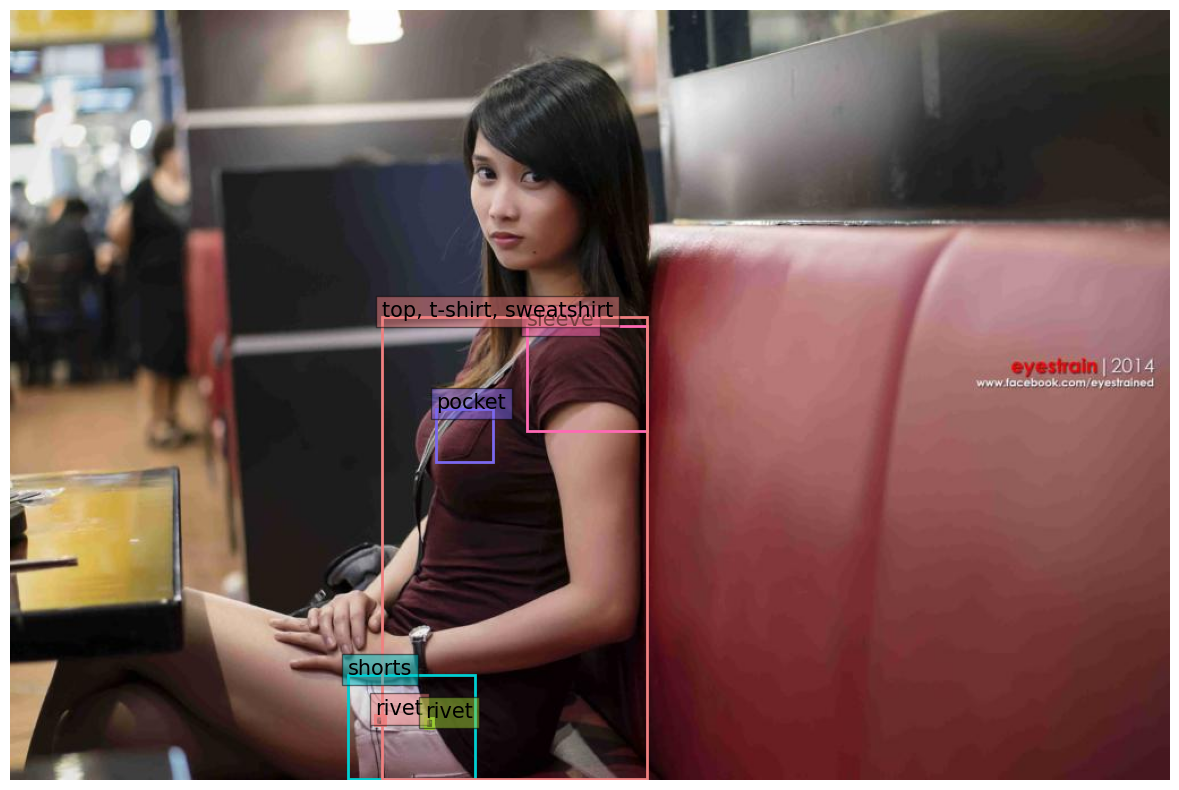

In [ ]:
random_i = random.randint(0, train_dataset.num_rows)
print(f"Plotting random item {random_i}")
random_item = train_dataset[random_i]
plot_results(random_item['image'], random_item['objects']['bbox'], idx_to_text(random_item['objects']['category']))

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=816, max_size=864)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [ ]:
def transform(batch):
    inputs = {}
    image = batch['image']
    image = fix_channels(ToTensor()(image[0]))
    inputs['pixel_values'] = feature_extractor([image], return_tensors='pt')['pixel_values']
    labels = []
    bbox = [rescale_bboxes(batch['objects'][i]['bbox'], (batch['width'][i], batch['height'][i])) for i in range(len(batch['objects']))]
    bbox = [xyxy_to_xcycwh(torch.Tensor(bbox_i)) for bbox_i in bbox]
    labels.append({
        "boxes": bbox,
        "class_labels": [object['category'] for object in batch['objects']],
        "image_id": torch.Tensor([batch['image_id']]).int(),
        "area": [object['area'] for object in batch['objects']],
        "iscrowd": torch.Tensor([0 for _ in batch['objects']]).int(),
        "orig_size": torch.Tensor([(batch['width'], batch['height'])]).int(),
        "size": torch.Tensor([inputs['pixel_values'].shape[1:]])[0].int(),
    })
    inputs['labels'] = labels
    return inputs

In [ ]:
prepared_train = train_dataset.with_transform(transform)
prepared_val = val_dataset.with_transform(transform)

In [ ]:
def collate_fn(batch):
    collated = {}
    collated["pixel_values"] = feature_extractor.pad([item['pixel_values'] for item in batch], return_tensors="pt")['pixel_values']
    collated["labels"] = []
    for item in batch:
        item['labels']['boxes'] = torch.stack(item['labels']['boxes'])[0]
        item['labels']['area'] = torch.Tensor(item['labels']['area'])
        item['labels']['class_labels'] = torch.Tensor(item['labels']['class_labels'])[0]
        item['labels']['class_labels'] = item['labels']['class_labels'].type(torch.LongTensor)
        collated["labels"].append(item['labels'])
    return collated

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 43320
Number of validation examples: 2280


In [ ]:
BATCH_SIZE = 1
train_dataloader = DataLoader(prepared_train, collate_fn=collate_fn, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(prepared_val, collate_fn=collate_fn, batch_size=BATCH_SIZE)

In [ ]:
item = next(iter(train_dataloader))

In [ ]:
random_i = random.randint(0, BATCH_SIZE-1)
random_i = 0
pil_image = transforms.ToPILImage()(item['pixel_values'][random_i])
class_labels = item['labels'][random_i]['class_labels']
size = pil_image.size
boxes = rescale_bboxes(cxcywh_to_xyxy(item['labels'][random_i]['boxes']), size, down=False)
plot_results(pil_image, boxes, idx_to_text(class_labels.tolist()))

NameError: name 'BATCH_SIZE' is not defined

In [ ]:
class Yolo(pl.LightningModule):
     def __init__(self, lr, weight_decay):
         super().__init__()
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small", num_labels=cats.num_classes, ignore_mismatched_sizes=True)
         self.lr = lr
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)
       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [ ]:
model = Yolo(lr=2.5e-5, weight_decay=1e-4)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([47]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([47, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(max_epochs=1, accelerator="gpu", devices=1)
trainer.fit(model)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                    | Params | Mode
---------------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M | eval
---------------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.670   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type                    | Params | Mode
---------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
import torch

save_path = "model/yolo_model.pth"
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to model/yolo_model.pth


# test

In [ ]:
model = Yolo(lr=2.5e-5, weight_decay=1e-4)
model.load_state_dict(torch.load("/content/yolo_model.pth"))
model.eval()
print(f"Model loaded from /content/yolo_model.pth")

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([47]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([47, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from /content/yolo_model.pth


In [ ]:
model.eval()

Detr(
  (model): YolosForObjectDetection(
    (vit): YolosModel(
      (embeddings): YolosEmbeddings(
        (patch_embeddings): YolosPatchEmbeddings(
          (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (interpolation): InterpolateInitialPositionEmbeddings()
      )
      (encoder): YolosEncoder(
        (layer): ModuleList(
          (0-11): 12 x YolosLayer(
            (attention): YolosSdpaAttention(
              (attention): YolosSdpaSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): YolosSelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
                (dropout

In [ ]:
def fix_channels(t):
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

In [ ]:
cats = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

def idx_to_text(i):
    return cats[i]

In [ ]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        ax.text(xmin, ymin, idx_to_text(cl), fontsize=10,
                bbox=dict(facecolor=c, alpha=0.8))
    plt.axis('off')
    plt.show()
    plt.savefig("image.png")

In [ ]:
def visualize_predictions(image, outputs, threshold=0.8):
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    plot_results(image, probas[keep], bboxes_scaled)

In [ ]:
from PIL import Image
from transformers import YolosFeatureExtractor, YolosForObjectDetection
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage

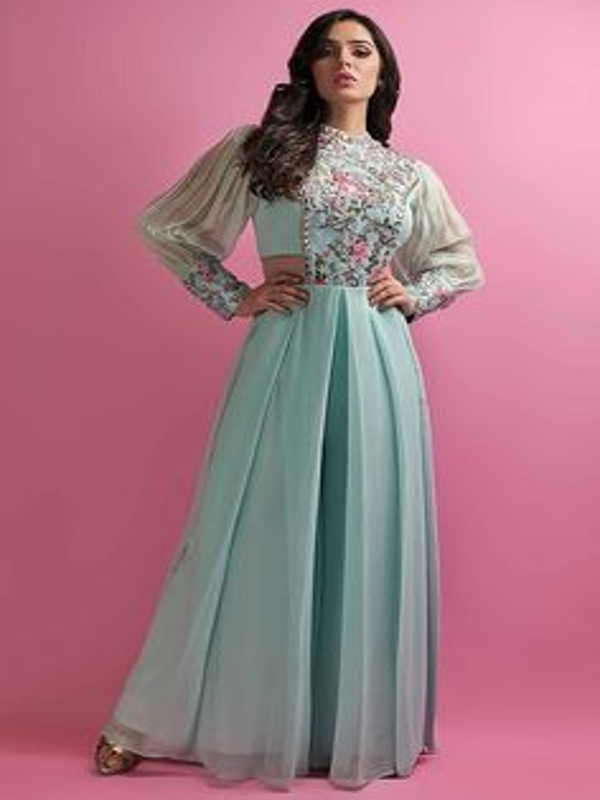

In [ ]:
image = Image.open(open("/content/eded.jpg", "rb"))
image = fix_channels(ToTensor()(image))
image = image.resize((600, 800))
image

In [ ]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

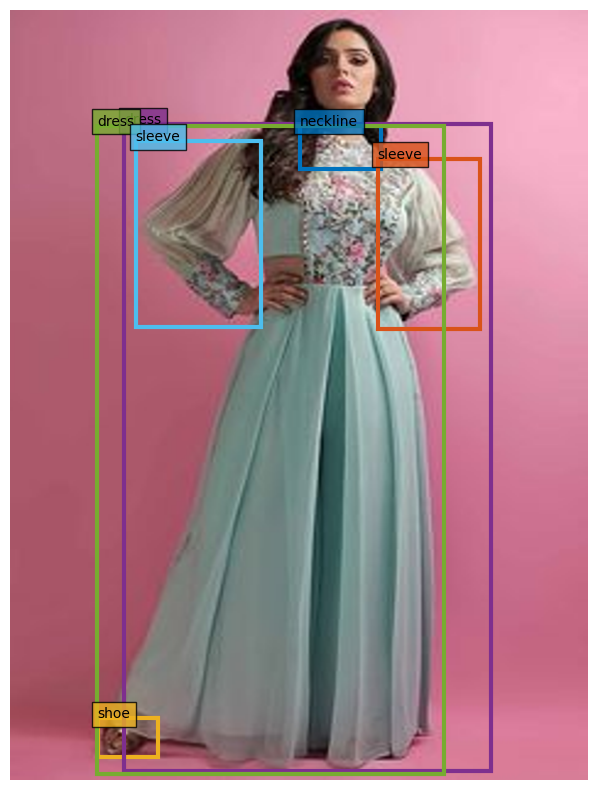

<Figure size 640x480 with 0 Axes>

In [ ]:
img = visualize_predictions(image, outputs, threshold=0.5)
img

# testing class

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage
from transformers import AutoFeatureExtractor, YolosForObjectDetection
from PIL import Image
import lightning as pl
import random
from lightning import Trainer
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage
from transformers import AutoFeatureExtractor
from transformers import AutoModelForObjectDetection

class Yolo(pl.LightningModule):
     def __init__(self, lr, weight_decay):
         super().__init__()
         self.categories = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small", num_labels=len(self.categories), ignore_mismatched_sizes=True)
         self.lr = lr
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)
       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

class YOLOVisualizer:
    def __init__(self, model_path = "yolo_model.pth" , feature_extractor_name="hustvl/yolos-small", lr=2.5e-5, weight_decay=1e-4):
        self.model = Yolo(lr=lr, weight_decay=weight_decay)
        self.model.load_state_dict(torch.load(model_path))
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(feature_extractor_name)
        self.categories = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

    def fix_channels(self, t):
        if len(t.shape) == 2:
            return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
        if t.shape[0] == 4:
            return ToPILImage()(t[:3])
        if t.shape[0] == 1:
            return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
        return ToPILImage()(t)

    def idx_to_text(self, i):
        return self.categories[i]

    def box_cxcywh_to_xyxy(self, x):
        x_c, y_c, w, h = x.unbind(1)
        b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
             (x_c + 0.5 * w), (y_c + 0.5 * h)]
        return torch.stack(b, dim=1)

    def rescale_bboxes(self, out_bbox, size):
        img_w, img_h = size
        b = self.box_cxcywh_to_xyxy(out_bbox)
        b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
        return b

    def plot_results(self, pil_img, prob, boxes):
        COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
                  [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
        plt.figure(figsize=(16, 10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=3))
            cl = p.argmax()
            ax.text(xmin, ymin, self.idx_to_text(cl), fontsize=10,
                    bbox=dict(facecolor=c, alpha=0.8))
        plt.axis('off')
        plt.show()
        plt.savefig("image.png")

    def visualize_predictions(self, image, outputs, threshold=0.8):
        probas = outputs.logits.softmax(-1)[0, :, :-1]
        keep = probas.max(-1).values > threshold

        bboxes_scaled = self.rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

        self.plot_results(image, probas[keep], bboxes_scaled)

    def process_image(self, image_path, resize_dims=(600, 800), threshold=0.5):
        image = Image.open(image_path)
        image = self.fix_channels(ToTensor()(image))
        image = image.resize(resize_dims)

        inputs = self.feature_extractor(images=image, return_tensors="pt")
        outputs = self.model(**inputs)

        self.visualize_predictions(image, outputs, threshold)


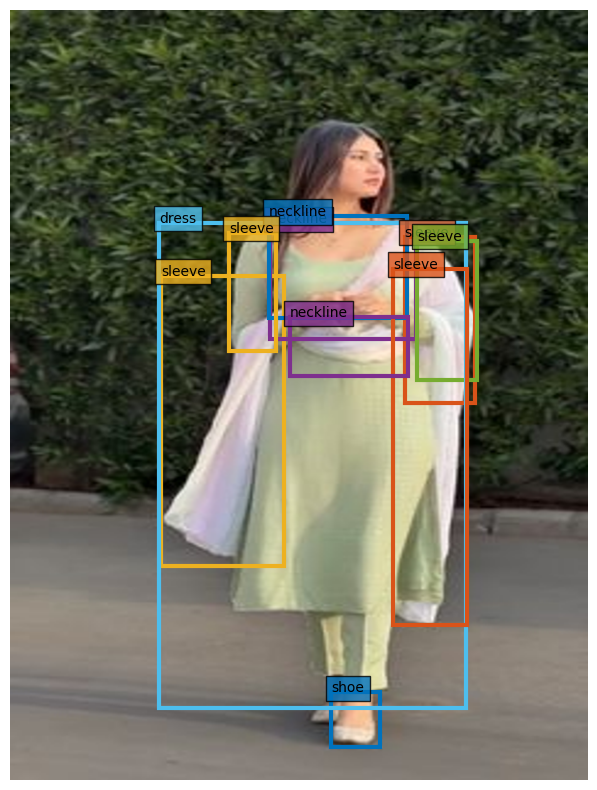

<Figure size 640x480 with 0 Axes>

In [ ]:
visualizer.process_image("/content/frty.jpg")

In [ ]:
visualizer = YOLOVisualizer()
visualizer.process_image("/content/jijik.jpg")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
import cv2
import numpy as np
import colorsys
from PIL import Image
import webcolors
import tensorflow as tf
from tensorflow.keras.preprocessing import image as tf_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

CSS3_NAMES_TO_HEX = {
    'Red': '#ff0000',
    'Copper': '#b87333',
    'Orange': '#ffa500',
    'Gold': '#ffd700',
    'Yellow': '#ffff00',
    'Lime Green': '#32cd32',
    'Green': '#008000',
    'Teal': '#008080',
    'Blue': '#0000ff',
    'Navy Blue': '#000080',
    'Purple': '#800080',
    'Pink': '#ffc0cb',
    'Black': '#000000',
    'White': '#ffffff',
    'Grey': '#808080'
}

class ClothingClassifier:
    def __init__(self, sub_model_path = "/content/models/model_sub", top_model_path = "/content/models/model_top", bottom_model_path = "/content/models/model_bottom", foot_model_path = "/content/models/model_foot"):
        self.sub_model = tf.keras.models.load_model(sub_model_path)
        self.top_model = tf.keras.models.load_model(top_model_path)
        self.bottom_model = tf.keras.models.load_model(bottom_model_path)
        self.foot_model = tf.keras.models.load_model(foot_model_path)

        self.sub_list = ["bottom", "foot", "top"]
        self.top_list = [['Belts', 'Blazers', 'Dresses', 'Dupatta', 'Jackets', 'Kurtas',
                        'Kurtis', 'Lehenga Choli', 'Nehru Jackets', 'Rain Jacket',
                        'Rompers', 'Shirts', 'Shrug', 'Suspenders', 'Sweaters',
                        'Sweatshirts', 'Tops', 'Tshirts', 'Tunics', 'Waistcoat'],
                        ['Boys', 'Girls', 'Men', 'Unisex', 'Women'],
                        ['Black', 'Blue', 'Dark Blue', 'Dark Green', 'Dark Yellow', 'Green',
                        'Grey', 'Light Blue', 'Multi', 'Orange', 'Pink', 'Purple', 'Red',
                        'White', 'Yellow'],
                        ['Fall', 'Spring', 'Summer', 'Winter'],
                        ['Casual', 'Ethnic', 'Formal', 'Party', 'Smart Casual', 'Sports',
                        'Travel']]
        self.bottom_list = [['Capris', 'Churidar', 'Jeans', 'Jeggings', 'Leggings', 'Patiala',
                            'Salwar', 'Salwar and Dupatta', 'Shorts', 'Skirts', 'Stockings',
                            'Swimwear', 'Tights', 'Track Pants', 'Tracksuits', 'Trousers'],
                            ['Boys', 'Girls', 'Men', 'Unisex', 'Women'],
                            ['Black', 'Blue', 'Dark Blue', 'Dark Green', 'Dark Yellow', 'Grey',
                            'Light Blue', 'Multi', 'Orange', 'Pink', 'Purple', 'Red', 'White',
                            'Yellow'],
                            ['Fall', 'Spring', 'Summer', 'Winter'],
                            ['Casual', 'Ethnic', 'Formal', 'Smart Casual', 'Sports']]
        self.foot_list = [['Casual Shoes', 'Flats', 'Flip Flops', 'Formal Shoes', 'Heels',
                        'Sandals', 'Sports Sandals', 'Sports Shoes'],
                        ['Boys', 'Girls', 'Men', 'Unisex', 'Women'],
                        ['Black', 'Blue', 'Dark Blue', 'Dark Green', 'Dark Orange',
                        'Dark Yellow', 'Grey', 'Light Blue', 'Multi', 'Orange', 'Pink',
                        'Purple', 'Red', 'White', 'Yellow'],
                        ['Fall', 'Spring', 'Summer', 'Winter'],
                        ['Casual', 'Ethnic', 'Formal', 'Party', 'Smart Casual', 'Sports']]

    def classify_image(self, image_path):
        train_images = np.zeros((1, 80, 60, 3))
        img = cv2.imread(image_path)

        if img.shape != (80, 60, 3):
            img = tf_image.load_img(image_path, target_size=(80, 60, 3))

        train_images[0] = img
        result2 = self.sub_list[np.argmax(self.sub_model.predict(train_images))]

        if result2 == "top":
            res = self.single_helper(train_images, self.top_model, self.top_list)
        elif result2 == "bottom":
            res = self.single_helper(train_images, self.bottom_model, self.bottom_list)
        elif result2 == "foot":
            res = self.single_helper(train_images, self.foot_model, self.foot_list)

        color_name = self.color_classification(image_path)
        res.append(color_name)
        res.append(image_path)
        res_str = f"{res[0]}, {res[1]}, {res[5]}, {res[3]}, {res[4]}"
        return res_str

    def single_helper(self, train_images, my_model, lelist):
        my_predictions = my_model.predict(train_images)
        result = []
        for i in range(len(lelist)):
            type_predicted_label = np.argmax(my_predictions[i][0])
            result.append(lelist[i][type_predicted_label])
        return result

    def color_classification(self, image_path):
        image = Image.open(image_path)
        image = image.convert('RGB')
        return self.get_cloth_color(image)

    def get_cloth_color(self, image):
        max_score = 0.0001
        dominant_color = None
        for count, (r, g, b) in image.getcolors(image.size[0] * image.size[1]):
            saturation = colorsys.rgb_to_hsv(r / 255.0, g / 255.0, b / 255.0)[1]
            y = min(abs(r * 2104 + g * 4130 + b * 802 + 4096 + 131072) >> 13, 235)
            y = (y - 16.0) / (235 - 16)
            if y > 0.9:
                continue
            score = (saturation + 0.1) * count
            if score > max_score:
                max_score = score
                dominant_color = (r, g, b)
        return self.get_color_name(dominant_color)

    def get_color_name(self, rgb_tuple):
        try:
            hex_value = webcolors.rgb_to_hex(rgb_tuple)
            return webcolors.hex_to_name(hex_value)
        except ValueError:
            return self.closest_color(rgb_tuple)

    def closest_color(self, requested_color):
        min_colors = {}
        for name, hex_value in CSS3_NAMES_TO_HEX.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(hex_value)
            rd = (r_c - requested_color[0]) ** 2
            gd = (g_c - requested_color[1]) ** 2
            bd = (b_c - requested_color[2]) ** 2
            min_colors[(rd + gd + bd)] = name
        return min_colors[min(min_colors.keys())]


classifier = ClothingClassifier()



In [ ]:
image_path = "/content/image_7.jpg"
result = classifier.classify_image(image_path)
print("Classification Result:", result)

1/1 [==============================] - 0s 26ms/step
Classification Result: Tops, Women, Pink, Summer, Casual


In [ ]:
[["Coat", "Women", "White", "Summer", "Casual", "Long Sleeves"],
["Shorts", "Women", "Navy Blue", "Summer", "Casual"],
["Trousers", "Men", "Black", "Summer", "Formal"],
["Shorts", "Men", "Teal", "Summer", "Sports" ],
["Tops", "Women", "Pink", "Summer", "Casual" , "round neck"]]

In [19]:
import requests
from PIL import Image
from io import BytesIO

def fetch_and_save_image_as_jpg(url, save_path):
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Read the image data from the response content
        img_data = BytesIO(response.content)

        # Open the image using PIL
        img = Image.open(img_data).convert('RGB')  # Convert image to RGB for JPG format

        # Save the image to the specified path with JPG format
        img.save(save_path, 'JPEG')
        print(f"Image saved to {save_path}")

    except requests.RequestException as e:
        print(f"Error fetching image from {url}: {e}")
    except IOError as e:
        print(f"Error saving image from {url}: {e}")

# Example URLs
image_urls = ['https://img101.urbanic.com/v1/goods-pic/555ec92d59f1413398408ebedbb89f1eUR_w750_q90.webp',
 'https://img101.urbanic.com/v1/43315dd4017f472482562d6fdf65face.webp',
 'https://img101.urbanic.com/v1/goods-pic/1197eecac64a4ed38f02ab149f7fdd39UR_w750_q90.webp',
 'https://img101.urbanic.com/v1/43315dd4017f472482562d6fdf65face.webp',
 'https://img101.urbanic.com/v1/goods-pic/f58d3961587841129bc13de2306e5321UR_w750_q90.webp',
 'https://img101.urbanic.com/v1/43315dd4017f472482562d6fdf65face.webp',
 'https://img101.urbanic.com/v1/goods-pic/3eaaef3139044e68a6d2e24077005201UR_w750_q90.webp',
 'https://img101.urbanic.com/v1/43315dd4017f472482562d6fdf65face.webp',
 'https://img101.urbanic.com/v1/goods-pic/2c8a3f11eabb4c9dbb19fcd7ff9feb39UR_w750_q90.webp',
 'https://img101.urbanic.com/v1/goods-pic/f8d5b8f6ff5c43b787e13297076f1152UR_w750_q90.webp',
 'https://i.pinimg.com/236x/3b/1d/1d/3b1d1d5c2114802ae81c968df7ec9e4c.jpg']

for idx, url in enumerate(image_urls):
    save_path = f'image_{idx + 1}.jpg'  # Save each image with a unique name and JPG extension
    fetch_and_save_image_as_jpg(url, save_path)
    result = classifier.classify_image(save_path)
    print("Classification Result:", result)

Image saved to image_1.jpg
1/1 [==============================] - 0s 24ms/step
Classification Result: Shirts, Women, Pink, Summer, Casual
Image saved to image_2.jpg
1/1 [==============================] - 0s 23ms/step
Classification Result: Shorts, Women, Navy Blue, Summer, Casual
Image saved to image_3.jpg
1/1 [==============================] - 0s 23ms/step
Classification Result: Trousers, Men, Black, Summer, Formal
Image saved to image_4.jpg
1/1 [==============================] - 0s 23ms/step
Classification Result: Shorts, Women, Navy Blue, Summer, Casual
Image saved to image_5.jpg
1/1 [==============================] - 0s 22ms/step
Classification Result: Shorts, Men, Teal, Summer, Sports
Image saved to image_6.jpg
1/1 [==============================] - 0s 24ms/step
Classification Result: Shorts, Women, Navy Blue, Summer, Casual
Image saved to image_7.jpg
1/1 [==============================] - 0s 23ms/step
Classification Result: Tops, Women, Pink, Summer, Casual
Image saved to image_8

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def fetch_and_save_image(url, save_path):
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Read the image data from the response content
        img_data = BytesIO(response.content)

        # Open the image using PIL
        img = Image.open(img_data)

        # Save the image to the specified path
        img.save(save_path)
        print(f"Image saved to {save_path}")

    except requests.RequestException as e:
        print(f"Error fetching image from {url}: {e}")
    except IOError as e:
        print(f"Error saving image from {url}: {e}")

# List of image URLs
image_urls = [
    'https://img101.urbanic.com/v1/goods-pic/555ec92d59f1413398408ebedbb89f1eUR_w750_q90.webp',
    'https://img101.urbanic.com/v1/43315dd4017f472482562d6fdf65face.webp',
    'https://img101.urbanic.com/v1/goods-pic/1197eecac64a4ed38f02ab149f7fdd39UR_w750_q90.webp',
    'https://img101.urbanic.com/v1/43315dd4017f472482562d6fdf65face.webp',
    'https://img101.urbanic.com/v1/goods-pic/f58d3961587841129bc13de2306e5321UR_w750_q90.webp',
    'https://img101.urbanic.com/v1/43315dd4017f472482562d6fdf65face.webp',
    'https://img101.urbanic.com/v1/goods-pic/3eaaef3139044e68a6d2e24077005201UR_w750_q90.webp',
    'https://img101.urbanic.com/v1/43315dd4017f472482562d6fdf65face.webp',
    'https://img101.urbanic.com/v1/goods-pic/2c8a3f11eabb4c9dbb19fcd7ff9feb39UR_w750_q90.webp',
    'https://img101.urbanic.com/v1/goods-pic/f8d5b8f6ff5c43b787e13297076f1152UR_w750_q90.webp',
    'https://i.pinimg.com/236x/3b/1d/1d/3b1d1d5c2114802ae81c968df7ec9e4c.jpg'
]

# Loop through the URLs and save the images with a unique name
for idx, url in enumerate(image_urls):
    save_path = f'image_{idx + 1}.webp'  # Save each image with a unique name
    fetch_and_save_image(url, save_path)


Image saved to image_1.webp
Image saved to image_2.webp
Image saved to image_3.webp
Image saved to image_4.webp
Image saved to image_5.webp
Image saved to image_6.webp
Image saved to image_7.webp
Image saved to image_8.webp
Image saved to image_9.webp
Image saved to image_10.webp
Image saved to image_11.webp
